Przygotowanie danych historycznych.
Główne funkcjonalności: \
1) czytywanie danych giełdowych z wielu plików CSV. \
2) Dodawanie informacji o tickerze (symbolu akcji). \
3) Filtrowanie danych na podstawie liczby rekordów i zakresu dat. \
4) Obliczanie zwrotu z inwestycji w oknach czasowych oraz ilustrowanie ich graficznie.
5) model predykcji zwrotów oparty na regresji liniowej- wyznaczenie parametrów metodą najmniejszych kwadratów

In [27]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, DoubleType
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from datetime import datetime
import os
from pyspark.sql.functions import to_date
from functools import reduce
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest, levene, boxcox
from statsmodels.stats.diagnostic import acorr_ljungbox
import pandas as pd
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
input_dir = '/content/drive/My Drive/HSBC'

In [29]:
spark = SparkSession.builder \
    .appName("Stocks Data Analysis") \
    .getOrCreate()

In [30]:
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

In [31]:
# Schemat dla plików CSV
schema = StructType([
    StructField("Date", StringType(), True),
    StructField("Close", DoubleType(), True)
])

In [32]:
def process_file(file_path, n_steps):
    df = spark.read.csv(file_path, schema=schema, header=False)

    df = df.withColumn("Symbol", F.input_file_name()) \
        .withColumn("Symbol", F.element_at(F.split(F.col("Symbol"), "\\."), 1))

    # Dodanie kolumny zliczającej liczbę wierszy dla każdego Symbol, bez filtrowania.
    df = df.withColumn('count', F.count("Symbol").over(Window.partitionBy('Symbol')))

    # Konwersja kolumny "Date" na format daty.
    df = df.withColumn("Date", F.to_date(F.to_timestamp(F.col('Date'), 'yy-MM-dd')))
    df = df.filter(F.col("Date") >= datetime(2019, 1, 2)) \
           .filter(F.col('Date') <= datetime(2024, 12, 30))

    # Funkcja do obliczania zwrotu (rolling window)
    window = Window.partitionBy("Symbol").orderBy("Date").rowsBetween(1 - n_steps, 0)
    df = df.withColumn("return", \
                       (F.col("Close") - F.first("Close").over(window)) / F.first("Close").over(window))

    return df.orderBy("Symbol", "Date")

Liczba kroków jest równa 100 i jest to okno dwudziestu tygodni (giełda nie jest otwarta w weekedy). Obliczanie zwrotu z inwestycji dla każdego symbolu akcji w oknie czasowym o długości n_steps, a wynik jest dodawany do final_df. Teraz dane mogą być przetwarzane dalej lub eksportowane. Exportujemy dane do PandasDataFrame

In [33]:
# Obliczany jest zwrot z inwestycji (return) jako procentowa zmiana wartości w oknie czasowym o długości n_steps dni.
# Używane są okna czasowe (Window), które grupują dane według Symbol i sortują według daty.
n_steps = 100

all_files = [os.path.join(input_dir, f) for f in os.listdir(input_dir) if f.endswith('.csv')]

# Przetwarzanie każdego pliku jako osobny DataFrame i przechowywanie w słowniku
dataframes = {}
for file_path in all_files:
    # Klucz w słowniku to nazwa pliku bez rozszerzenia
    file_name = os.path.basename(file_path).split('.')[0]
    dataframes[file_name] = process_file(file_path, n_steps)

# Przykład dostępu do poszczególnych DataFrame'ów
for symbol, df in dataframes.items():
    print(f"Symbol: {symbol}")
    df.show(5)

Symbol: S&P_500_historical_data
+----------+-----------------+--------------------+-----+--------------------+
|      Date|            Close|              Symbol|count|              return|
+----------+-----------------+--------------------+-----+--------------------+
|2019-01-02|  2476.9599609375|file:///content/d...| 1512|                 0.0|
|2019-01-03|   2491.919921875|file:///content/d...| 1512|0.006039645845481423|
|2019-01-04|   2474.330078125|file:///content/d...| 1512|-0.00106173812010...|
|2019-01-07|2535.610107421875|file:///content/d...| 1512|0.023678277973527118|
|2019-01-08|2568.110107421875|file:///content/d...| 1512| 0.03679920060148076|
+----------+-----------------+--------------------+-----+--------------------+
only showing top 5 rows

Symbol: Dow_Jones_historical_data
+----------+---------------+--------------------+-----+--------------------+
|      Date|          Close|              Symbol|count|              return|
+----------+---------------+----------------

In [34]:
symbol = "S&P_500_historical_data"
for symbol in dataframes:
    final_df = dataframes[symbol]

    pandas_df = final_df.toPandas()

    # Dodanie nowej kolumny 'stock_returns' na podstawie kolumny 'Close'
    pandas_df = pandas_df.assign(stock_returns=pandas_df['Close'])

    print(pandas_df.head())

         Date        Close                                             Symbol  \
0  2019-01-02  2476.959961  file:///content/drive/My%20Drive/HSBC/S&P_500_...   
1  2019-01-03  2491.919922  file:///content/drive/My%20Drive/HSBC/S&P_500_...   
2  2019-01-04  2474.330078  file:///content/drive/My%20Drive/HSBC/S&P_500_...   
3  2019-01-07  2535.610107  file:///content/drive/My%20Drive/HSBC/S&P_500_...   
4  2019-01-08  2568.110107  file:///content/drive/My%20Drive/HSBC/S&P_500_...   

   count    return  stock_returns  
0   1512  0.000000    2476.959961  
1   1512  0.006040    2491.919922  
2   1512 -0.001062    2474.330078  
3   1512  0.023678    2535.610107  
4   1512  0.036799    2568.110107  
         Date         Close  \
0  2019-01-02  23058.609375   
1  2019-01-03  23176.390625   
2  2019-01-04  22894.919922   
3  2019-01-07  23474.259766   
4  2019-01-08  23680.320312   

                                              Symbol  count    return  \
0  file:///content/drive/My%20Drive/H

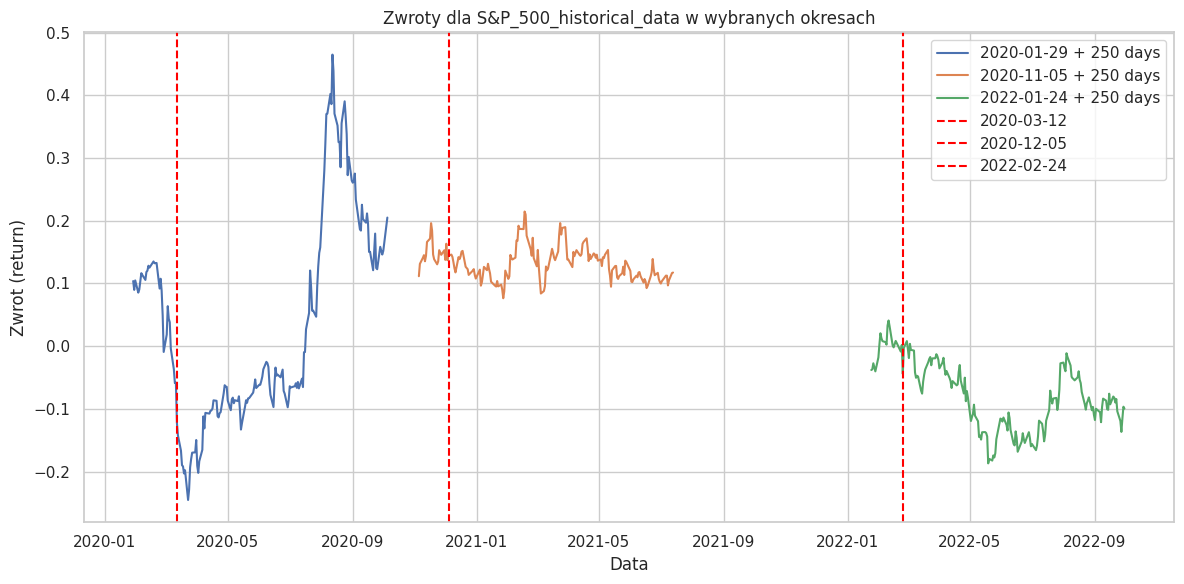

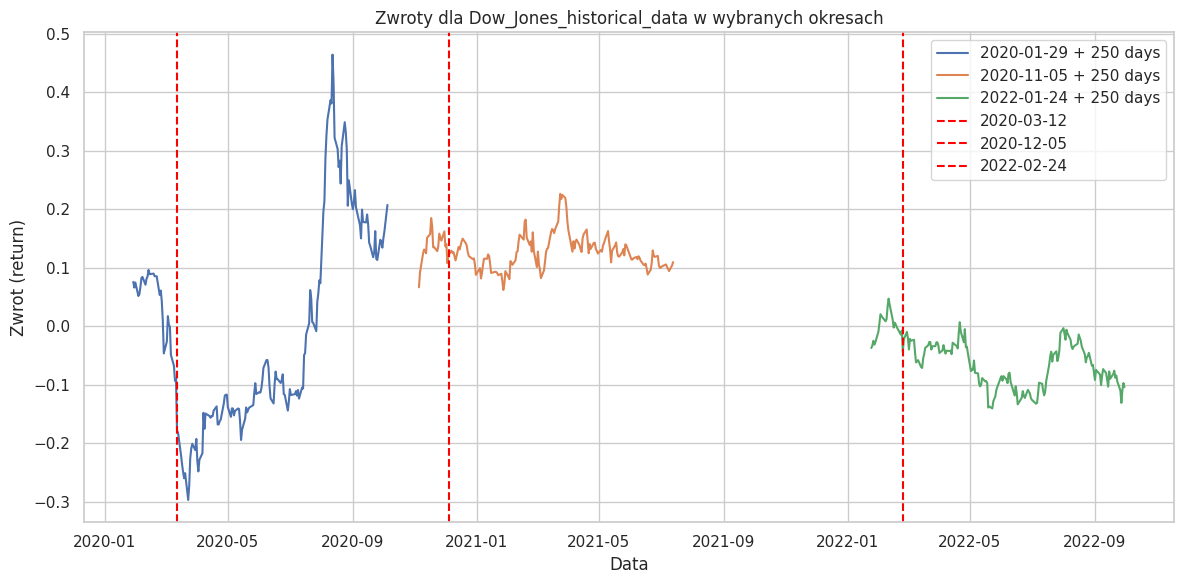

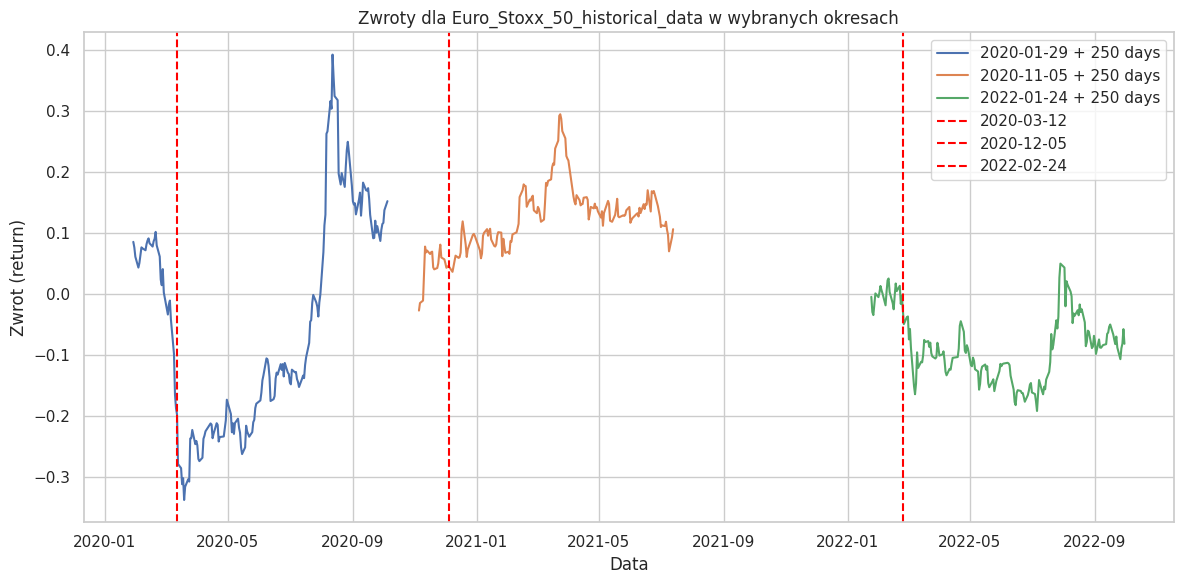

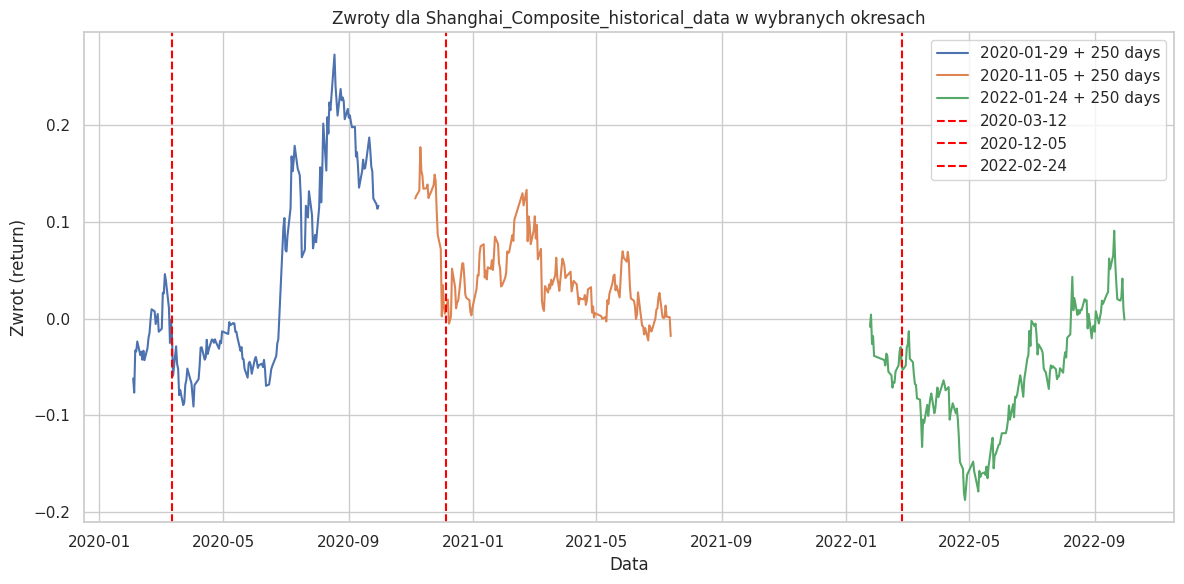

In [35]:
for symbol in dataframes:
    final_df = dataframes[symbol]
    pandas_df = final_df.toPandas()

    pandas_df['Date'] = pd.to_datetime(pandas_df['Date'])

    periods = [
        ("2020-01-29", 250),
        ("2020-11-05", 250),
        ("2022-01-24", 250)
    ]

    important_dates = [
        pd.to_datetime("2020-03-12"),
        pd.to_datetime("2020-12-05"),
        pd.to_datetime("2022-02-24")
    ]

    plt.figure(figsize=(12, 6))
    for start_date, days in periods:
        start_date = pd.to_datetime(start_date)
        end_date = start_date + pd.Timedelta(days=days)

        # Filtrowanie danych w tym przedziale czasowym
        filtered_data = pandas_df[(pandas_df['Date'] >= start_date) & (pandas_df['Date'] <= end_date)]

        plt.plot(
            filtered_data['Date'],
            filtered_data['return'],
            label=f"{start_date.date()} + {days} days"
        )
    for important_date in important_dates:
        plt.axvline(important_date, color='red', linestyle='--', label=f"{important_date.date()}")

    plt.title(f"Zwroty dla {symbol} w wybranych okresach")
    plt.xlabel("Data")
    plt.ylabel("Zwrot (return)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

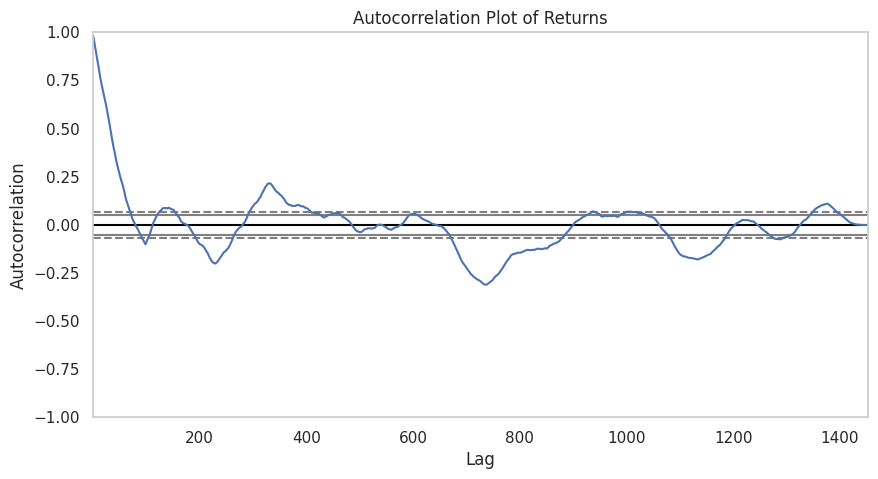

Ljung-Box Test Results:
         lb_stat  lb_pvalue
20  20288.712224        0.0
K-S Test between Segment 1 and Segment 2:
KS Statistic = 0.41367265469061876, p-value = 2.7043130433224737e-13
K-S Test between Segment 1 and Segment 3:
KS Statistic = 0.40718562874251496, p-value = 9.094488083136505e-13
K-S Test between Segment 2 and Segment 3:
KS Statistic = 0.6831337325349301, p-value = 1.3338338767991744e-37
Levene's Test for Equal Variances:
Statistic = 62.793316596598515, p-value = 4.739265797611886e-25


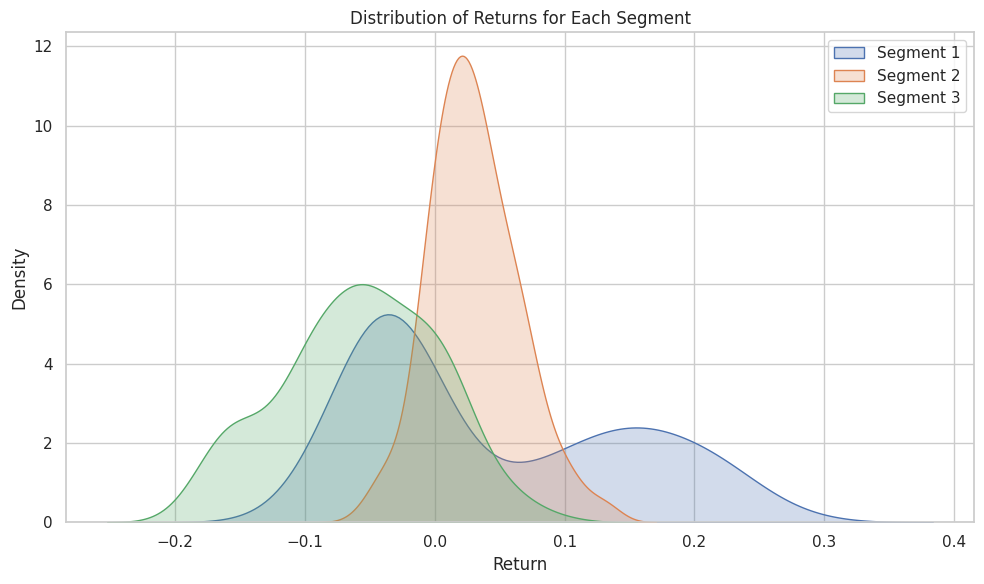

In [63]:
# Step 1: Test for Independence
# Compute Autocorrelation Function (ACF)
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
pd.plotting.autocorrelation_plot(pandas_df['return'])
plt.title("Autocorrelation Plot of Returns")
plt.show()

# Perform the Ljung-Box Test
lags = 20  # Number of lags to test
ljung_box_results = acorr_ljungbox(pandas_df['return'], lags=[lags], return_df=True)
print("Ljung-Box Test Results:")
print(ljung_box_results)

# Step 2: Test for Identical Distribution
# Divide the data into three periods
periods = [
    ("2020-01-29", 250),
    ("2020-12-05", 250),
    ("2022-02-24", 250)
]

segments = []
for start_date, days in periods:
    start_date = pd.to_datetime(start_date)
    end_date = start_date + pd.Timedelta(days=days)
    segment = pandas_df[(pandas_df['Date'] >= start_date) & (pandas_df['Date'] <= end_date)]['return']
    segments.append(segment)

# Kolmogorov-Smirnov (K-S) Test between segments
for i in range(len(segments)):
    for j in range(i + 1, len(segments)):
        ks_stat, ks_p_value = kstest(segments[i], segments[j])
        print(f"K-S Test between Segment {i + 1} and Segment {j + 1}:")
        print(f"KS Statistic = {ks_stat}, p-value = {ks_p_value}")

# Levene's Test for equal variances
levene_stat, levene_p_value = levene(*segments)
print("Levene's Test for Equal Variances:")
print(f"Statistic = {levene_stat}, p-value = {levene_p_value}")

# Step 3: Visualization of Distributions
plt.figure(figsize=(10, 6))
for i, segment in enumerate(segments):
    sns.kdeplot(segment, label=f"Segment {i + 1}", fill=True)
plt.xlabel("Return")
plt.ylabel("Density")
plt.title("Distribution of Returns for Each Segment")
plt.legend()
plt.tight_layout()
plt.show()
